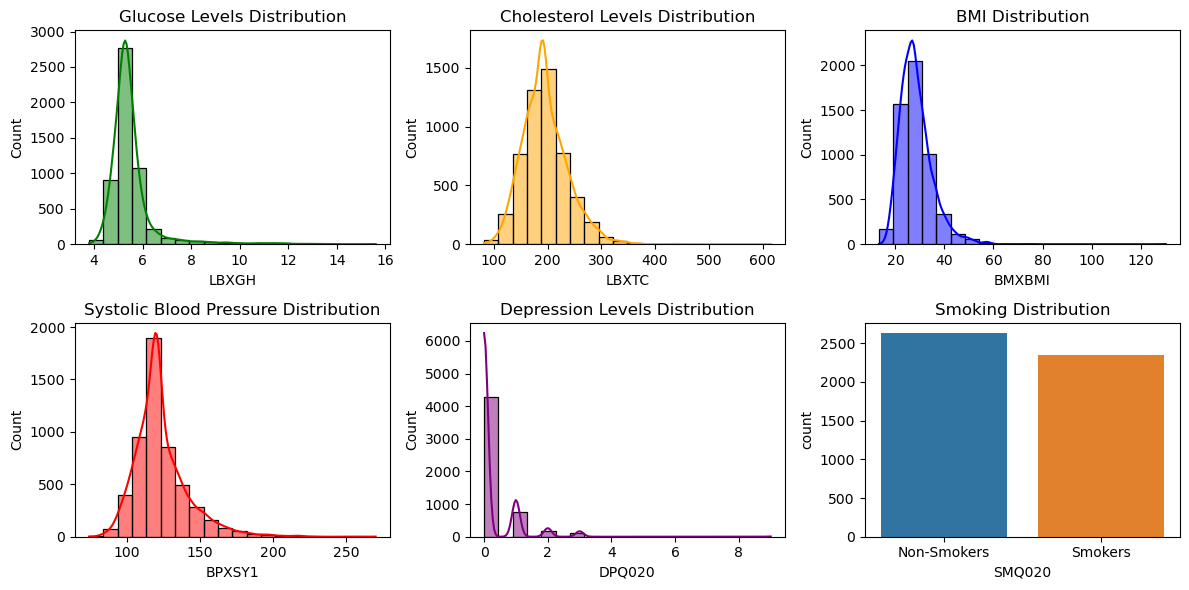

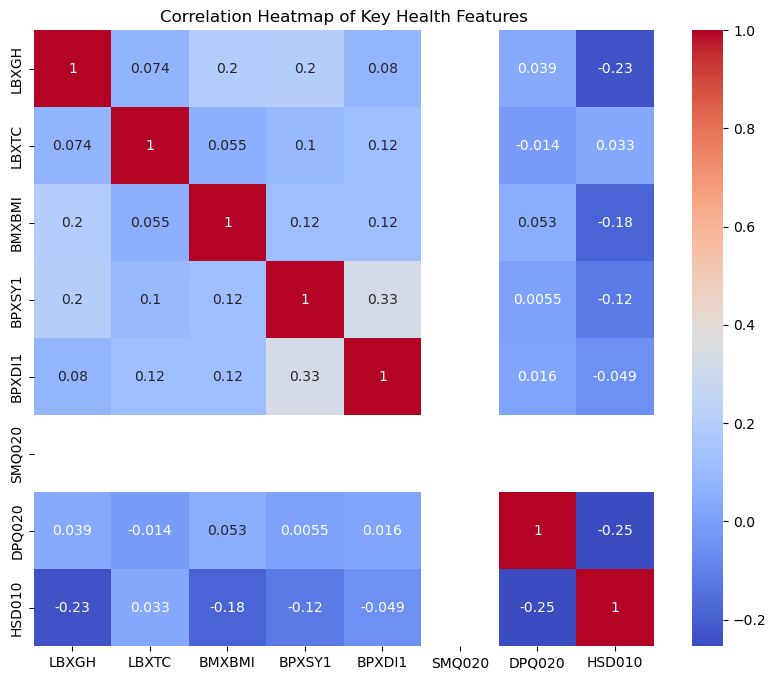

Classification Report for RandomForestClassifier: 
               precision    recall  f1-score   support

         1.0       0.17      0.02      0.04        43
         2.0       0.36      0.19      0.25       263
         6.0       0.46      0.70      0.56       713
         8.0       0.33      0.27      0.30       434
        10.0       0.11      0.01      0.02       148

    accuracy                           0.42      1601
   macro avg       0.29      0.24      0.23      1601
weighted avg       0.37      0.42      0.37      1601

Classification Report for BalancedRandomForestClassifier: 
               precision    recall  f1-score   support

         1.0       0.06      0.42      0.11        43
         2.0       0.25      0.27      0.26       263
         6.0       0.51      0.17      0.26       713
         8.0       0.36      0.26      0.30       434
        10.0       0.13      0.41      0.20       148

    accuracy                           0.24      1601
   macro avg       

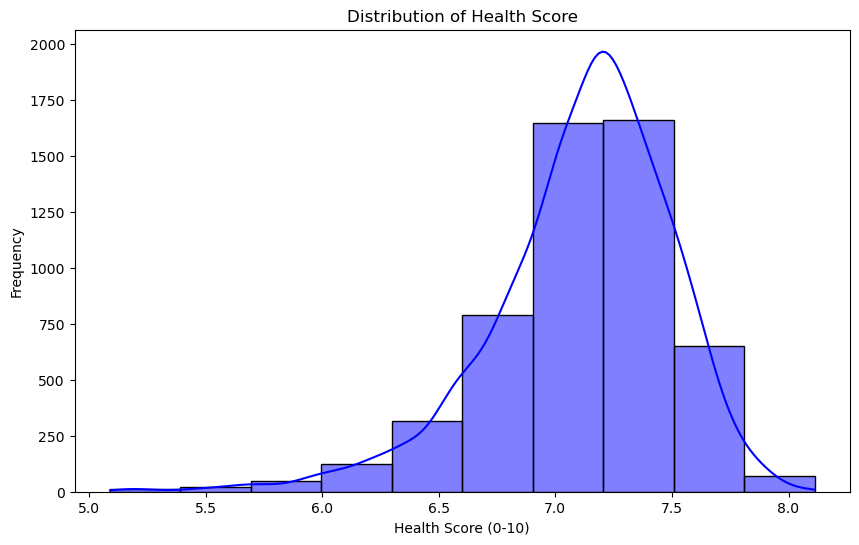

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load the NHANES datasets for 2005-2006 
glucose_data = pd.read_sas(r'GHB_D.XPT')          # Glycohemoglobin (Glucose) Lab Data
cholesterol_data = pd.read_sas(r'TCHOL_D.XPT')    # Total Cholesterol Lab Data
demo_data = pd.read_sas(r'BMX_D.XPT')            # Demographic Data (includes BMI, Weight)
bp_data = pd.read_sas(r'BPX_D.XPT')               # Blood Pressure Data
diet_data = pd.read_sas(r'DR1TOT_D.XPT')          # Dietary Data (Total Nutrient Intakes - Day 1)
smoking_data = pd.read_sas(r'SMQ_D.XPT')          # Smoking Questionnaire
mental_health_data = pd.read_sas(r'DPQ_D.XPT')    # Depression Questionnaire
healthstatus_data = pd.read_sas(r'HSQ_D.XPT')     # Self-reported Current Health Status

# Mapping data to for better understanding
healthstatus_data['HSD010'] = healthstatus_data['HSD010'].replace({1:10, 2:8, 3:6, 4:2, 5:1, 6:1, 9:1})
smoking_data['SMQ020'] = smoking_data['SMQ020'].replace({1:1, 2:0, 7:0, 9:0})

# Merge datasets on 'SEQN'
merged_data = pd.merge(glucose_data, cholesterol_data, on='SEQN', how='inner')
merged_data = pd.merge(merged_data, demo_data, on='SEQN', how='inner')
merged_data = pd.merge(merged_data, bp_data, on='SEQN', how='inner')
merged_data = pd.merge(merged_data, diet_data, on='SEQN', how='inner')
merged_data = pd.merge(merged_data, smoking_data, on='SEQN', how='inner')
merged_data = pd.merge(merged_data, mental_health_data, on='SEQN', how='inner')
merged_data = pd.merge(merged_data, healthstatus_data, on='SEQN', how='inner')

# Replacing missing values for cleaner analysis
features = ['LBXGH', 'LBXTC', 'BMXBMI', 'BPXSY1', 'BPXDI1', 'SMQ020', 'DPQ020']
final_data = merged_data[['LBXGH', 'LBXTC', 'BMXBMI', 'BPXSY1', 'BPXDI1', 'SMQ020', 'DPQ020', 'HSD010']]
final_data.fillna(0, inplace = True)

for feature in final_data.columns:
    median_value = np.median(final_data[feature][final_data[feature] != 0])  # Calculate median excluding zeros
    final_data[feature] = final_data[feature].replace(0, median_value) 

smoking_data['SMQ020'] = smoking_data['SMQ020'].astype('category')

# Exploratory Data Analysis (EDA)
# Distribution of key health-related features
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
sns.histplot(final_data['LBXGH'], bins=20, kde=True, color='green')
plt.title('Glucose Levels Distribution')

plt.subplot(2, 3, 2)
sns.histplot(final_data['LBXTC'], bins=20, kde=True, color='orange')
plt.title('Cholesterol Levels Distribution')

plt.subplot(2, 3, 3)
sns.histplot(final_data['BMXBMI'], bins=20, kde=True, color='blue')
plt.title('BMI Distribution')

plt.subplot(2, 3, 4)
sns.histplot(final_data['BPXSY1'], bins=20, kde=True, color='red')
plt.title('Systolic Blood Pressure Distribution')

plt.subplot(2, 3, 5)
sns.histplot(final_data['DPQ020'], bins=20, kde=True, color='purple')
plt.title('Depression Levels Distribution')

plt.subplot(2, 3, 6)
sns.countplot(x='SMQ020', data=smoking_data, hue = 'SMQ020', legend = False)
plt.xticks([0, 1], ['Non-Smokers', 'Smokers'])
plt.title('Smoking Distribution')

plt.tight_layout()
plt.show()

# Correlation Heatmap for Key Health Features
plt.figure(figsize=(10, 8))
sns.heatmap(final_data[['LBXGH', 'LBXTC', 'BMXBMI', 'BPXSY1', 'BPXDI1', 'SMQ020', 'DPQ020', 'HSD010']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Key Health Features')
plt.show()

# Feature Engineering: Creating health indicators and target variables
# Target variable for diabetes (Glucose > 126 mg/dL)
final_data['diabetes'] = final_data['LBXGH'] > 126

# Cholesterol target (Total cholesterol > 200 mg/dL)
final_data['high_cholesterol'] = final_data['LBXTC'] > 200

# Hypertension target (Blood Pressure: Systolic > 130 or Diastolic > 80)
final_data['high_bp'] = (final_data['BPXSY1'] > 130) | (final_data['BPXDI1'] > 80)

# Obesity indicator (BMI >= 30)
final_data['obesity'] = final_data['BMXBMI'] >= 30

# Smoking status (1 = Yes)
final_data['smoker'] = final_data['SMQ020'] == 1

# Depression level (PHQ-9 score, 0-27 scale)
final_data['depression'] = final_data['DPQ020']

# Health Score Calculation (Weighted combination of health factors, scaled to 10)
weights = {
    'LBXGH': 0.2,  # Glucose
    'LBXTC': 0.15, # Cholesterol
    'BMXBMI': 0.15,# BMI
    'BPXSY1': 0.2, # Systolic Blood Pressure
    'BPXDI1': 0.1, # Diastolic Blood Pressure
    'SMQ020': 0.1, # Smoking
    'DPQ020': 0.1   # Depression
}

# Normalization function
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

# Normalize each feature and calculate the weighted score
final_data['health_score'] = (
    weights['LBXGH'] * (1 - normalize(final_data['LBXGH'])) +  # Lower is better
    weights['LBXTC'] * (1 - normalize(final_data['LBXTC'])) +  # Lower is better
    weights['BMXBMI'] * (1 - normalize(final_data['BMXBMI'])) + # Lower is better
    weights['BPXSY1'] * (1 - normalize(final_data['BPXSY1'])) + # Lower is better
    weights['BPXDI1'] * (1 - normalize(final_data['BPXDI1'])) + # Lower is better
    weights['SMQ020'] * (1 - final_data['SMQ020']) +      # Higher is better
    weights['DPQ020'] * (1 - normalize(final_data['DPQ020']))  # Lower is better
)

# Scale health score to 0-10 range
final_data['health_score'] = final_data['health_score'] * 10

# Clip health score to ensure it's in the range [0, 10]
final_data['health_score'] = final_data['health_score'].clip(lower=0, upper=10)

# Prepare data for machine learning
X = final_data[features]
y = final_data['HSD010']

# Scaling Data
scaler = MinMaxScaler()  # You can use StandardScaler() instead if needed
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Split the data for Machine Learning
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Machine Learning Model (Random Forest for Classification)
model1 = RandomForestClassifier(random_state=42)
model1.fit(X_train, y_train)

# Machine Learning Model (Balanced Random Forest for Classification)
model2 = BalancedRandomForestClassifier(random_state=42)
model2.fit(X_train, y_train)

# Machine Learning Model (Logistic Regression for Classification)
model3 = LogisticRegression()
model3.fit(X_train, y_train)

# Predictions and evaluation
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

print('Classification Report for RandomForestClassifier: \n', classification_report(y_test, y_pred1))
print('Classification Report for BalancedRandomForestClassifier: \n', classification_report(y_test, y_pred2))
print('Classification Report for Logistic Regression: \n', classification_report(y_test, y_pred3))

# Basic Visualization: Distribution of Health Score
plt.figure(figsize=(10, 6))
sns.histplot(final_data['health_score'], bins=10, kde=True, color='blue')
plt.title('Distribution of Health Score')
plt.xlabel('Health Score (0-10)')
plt.ylabel('Frequency')
plt.show()
